In [1]:
import chess
import pyspark.sql.functions as F
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import seaborn as sns
# pyspark.sql.functions.split(df['my_str_col'], '-')

In [2]:
spark

In [3]:
raw = spark.read.format("parquet").option("header",True).load("data/chess_dataframe_parquet/*.parquet")

In [4]:
raw.show()

+--------------------+----+----------+-----+-----------------+----------------+-------+--------+---------------+----------+---+--------------------+--------------------+------------+-----------+----------+--------+--------+---------------+----------+--------------------+
|               Event|Site|      Date|Round|            White|           Black| Result|BlackElo|BlackRatingDiff|BlackTitle|ECO|          LichessURL|             Opening| Termination|TimeControl|   UTCDate| UTCTime|WhiteElo|WhiteRatingDiff|WhiteTitle|               Moves|
+--------------------+----+----------+-----+-----------------+----------------+-------+--------+---------------+----------+---+--------------------+--------------------+------------+-----------+----------+--------+--------+---------------+----------+--------------------+
|    Rated Blitz game|   ?|2020.10.01|    -|  andreas_heimann|       DR-MAOOZE|    1-0|    2458|             -3|      null|B00|https://lichess.o...|Nimzowitsch Defen...|      Normal|  

In [5]:
sp = F.split(raw.Opening, ':')
df = raw.withColumn("Opening1", sp.getItem(0)).withColumn("Variation", sp.getItem(1))

In [6]:
df = df.groupby(df.Opening1, df.Variation).count()

In [7]:
df.take(5)

[Row(Opening1='Sicilian Defense', Variation=' Nyezhmetdinov-Rossolimo Attack, Fianchetto Variation', count=12164),
 Row(Opening1='Alekhine Defense', Variation=' Balogh Variation', count=775),
 Row(Opening1="King's Indian Defense", Variation=' Fianchetto Variation, Larsen Defense', count=1100),
 Row(Opening1="Queen's Pawn Game", Variation=' Colle System, Grünfeld Formation', count=142),
 Row(Opening1='Nimzowitsch Defense', Variation=' Scandinavian Variation, Advance Variation', count=1129)]

In [8]:
x = df.filter(F.col("count")>100).sort(F.col("count").desc()).toPandas()
x.set_index(['Opening1', "Variation"], inplace=True)
x.sort_index(inplace=True)
display(HTML(x.to_html()))

## Total opening count table

In [9]:
df.groupby(df.Opening1).agg(F.sum("count").alias("count")) \
  .filter(F.col("count")>100).sort(F.col("count").desc()).toPandas()

,Opening1,count
0,Sicilian Defense,406103
1,English Opening,153129
2,French Defense,138297
3,Caro-Kann Defense,127070
4,Queen's Pawn Game,101094
...,...,...
172,"Blackmar-Diemer Gambit Declined, Brombacher Co...",110
173,"King's Gambit Accepted, Bishop's Gambit, Bogol...",108
174,"Benko Gambit Declined, Hjørring Countergambit",107
175,King's Gambit Declined,102


## Opening with its most popular variation count

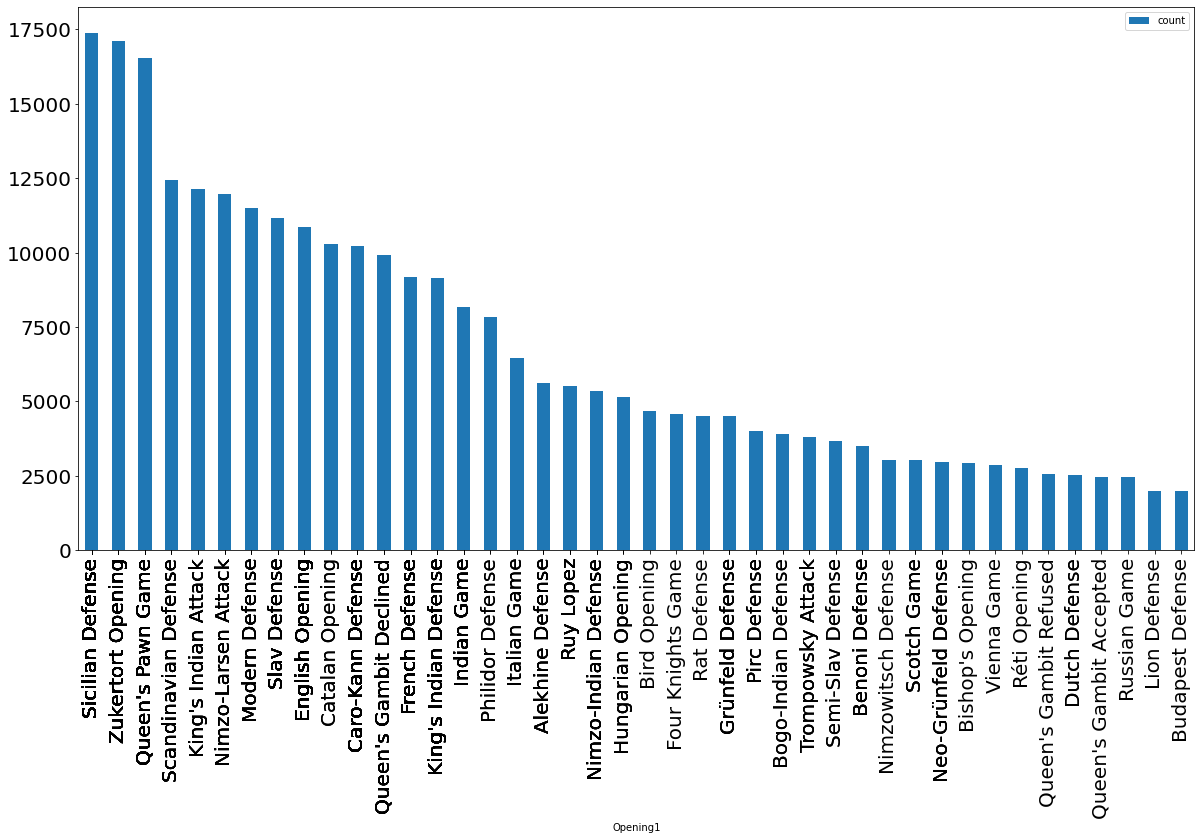

In [10]:
import matplotlib.pyplot as plt
p = df.filter(F.col("count")>2000).filter(F.col("variation").isNotNull()) \
      .sort(F.col("count").desc()) \
      .toPandas()
p.plot(x="Opening1", y="count", kind="bar", rot=90, fontsize=20, figsize=(20,10))
plt.show()

## Most played variation

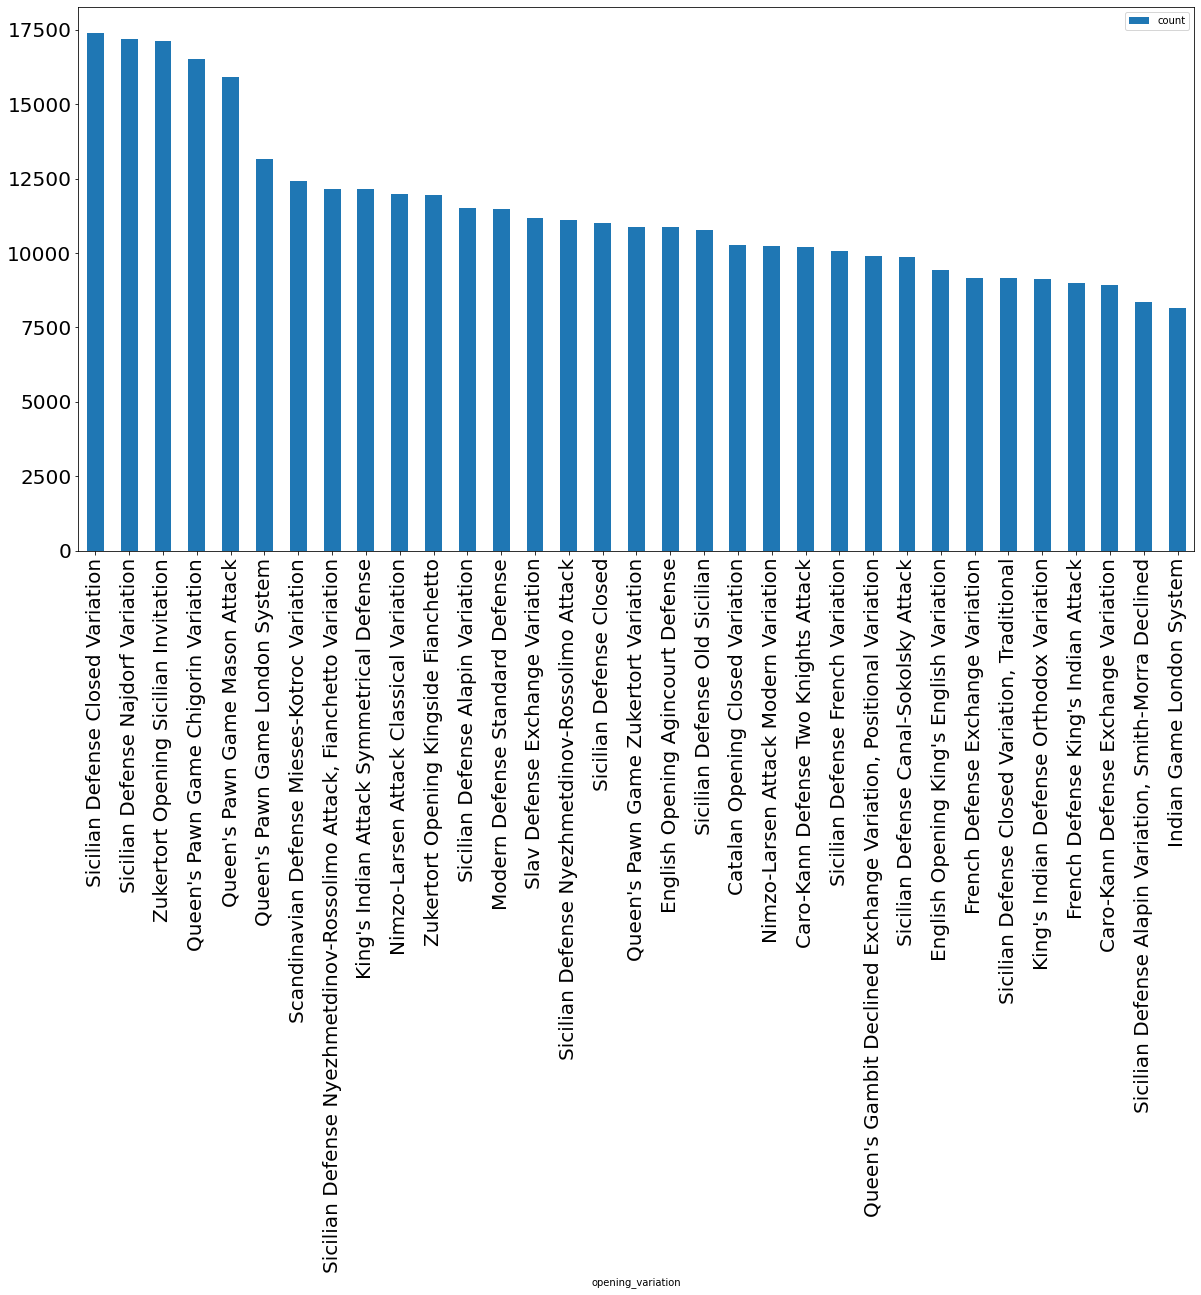

In [11]:
import matplotlib.pyplot as plt
p = df.filter(F.col("count")>8000).filter(F.col("variation").isNotNull()) \
      .withColumn("opening_variation", F.concat(F.col("Opening1"), F.col("variation"))).sort(F.col("count").desc()) \
      .toPandas()
p.plot(x="opening_variation", y="count", kind="bar", rot=90, fontsize=20, figsize=(20,10))
plt.show()

## Most played opening

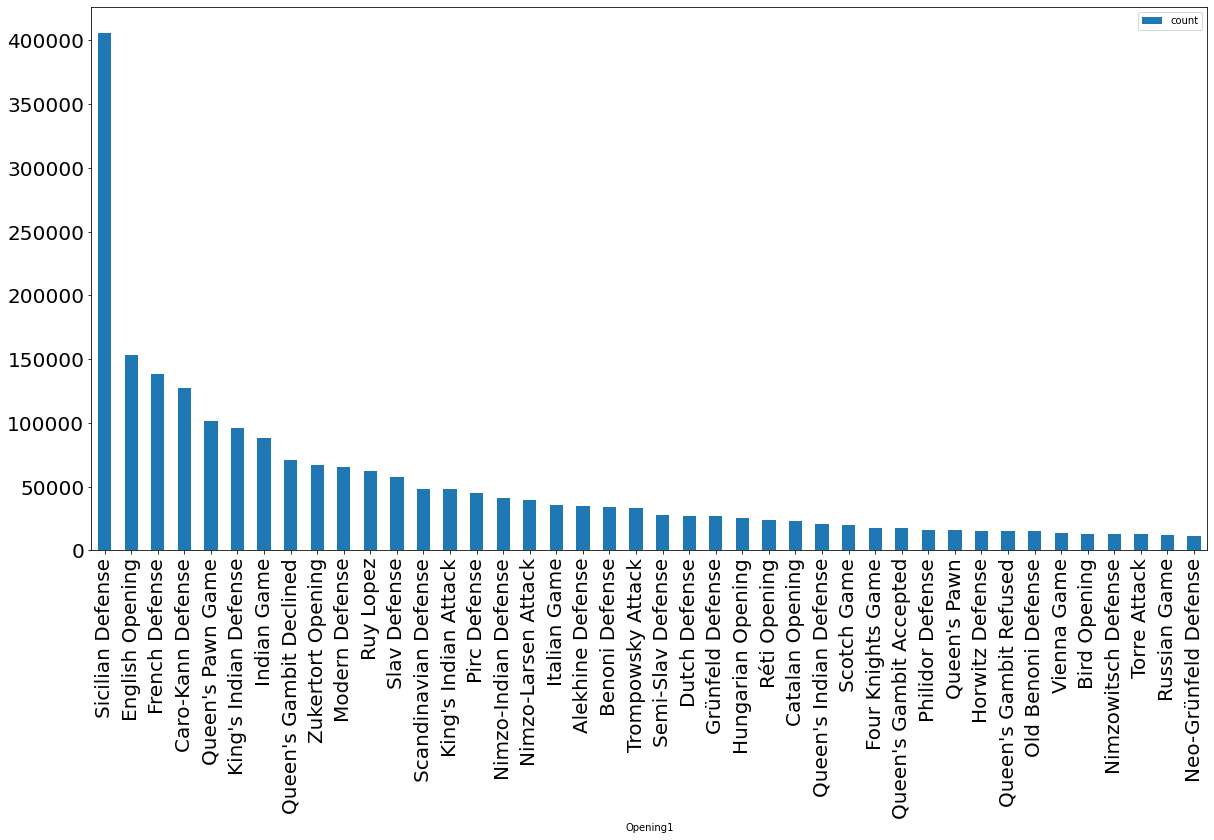

In [12]:
import matplotlib.pyplot as plt
df2 = raw.withColumn("Opening1", sp.getItem(0))
df2 = df2.groupby(df2.Opening1).count().sort(F.col("count").desc())
p = df2.filter(F.col("count")>10000).toPandas()
p.plot(x="Opening1", y="count", kind="bar", rot=90, fontsize=20, figsize=(20,10))
plt.show()

## Win rate

In [13]:
res = raw.select(["Result", "Opening"])
sp = F.split(res.Opening, ':')
res = res.withColumn("Opening_temp", sp.getItem(0)).withColumn("Variation", sp.getItem(1))
res = res.drop("Opening")
res = res.withColumnRenamed("Opening_temp", "Opening")

res = res.groupby("Opening", "Result").count()
res = res.withColumn("WonBy", F.when(res.Result == "0-1", F.lit("black")) \
                         .when(res.Result == "1-0", F.lit("white")) \
                         .when(res.Result == "1/2-1/2", F.lit("draw")) \
                         .otherwise(F.lit("aborted"))).drop("Result").sort(F.col("Opening").desc())

In [14]:
res.show()

+--------------------+-----+-------+
|             Opening|count|  WonBy|
+--------------------+-----+-------+
|   Zukertort Opening|28252|  black|
|   Zukertort Opening|    1|aborted|
|   Zukertort Opening|32073|  white|
|   Zukertort Opening| 6962|   draw|
|   Zukertort Defense|   23|  white|
|   Zukertort Defense|   13|  black|
|   Zukertort Defense|    1|   draw|
|       Zaire Defense|    1|  white|
|Yusupov-Rubinstei...| 1441|  black|
|Yusupov-Rubinstei...|  305|   draw|
|Yusupov-Rubinstei...| 1387|  white|
|        Ware Opening|  623|  white|
|        Ware Opening|  611|  black|
|        Ware Opening|   98|   draw|
|        Ware Defense|   54|   draw|
|        Ware Defense|  330|  black|
|        Ware Defense|  353|  white|
|        Wade Defense| 1083|  white|
|        Wade Defense|  283|   draw|
|        Wade Defense| 1110|  black|
+--------------------+-----+-------+
only showing top 20 rows



In [15]:
perc = res.groupby("Opening").agg(F.sum("count").alias("total"))

In [16]:
perc.show()

+--------------------+-----+
|             Opening|total|
+--------------------+-----+
|   Zukertort Opening|67288|
|   Zukertort Defense|   37|
|       Zaire Defense|    1|
|Yusupov-Rubinstei...| 3133|
|        Ware Opening| 1332|
|        Ware Defense|  737|
|        Wade Defense| 2476|
|     Vulture Defense|  203|
|         Vienna Game|13835|
|     Veresov Opening|   16|
|  Venezolana Opening|   34|
|Van't Kruijs Opening| 6959|
|    Van Geet Opening| 7401|
|    Valencia Opening|   78|
|   Trompowsky Attack|33379|
|        Torre Attack|12448|
|Three Knights Ope...| 1967|
|      Tayler Opening|    1|
|    Tarrasch Defense| 8750|
|              System|    2|
+--------------------+-----+
only showing top 20 rows



In [17]:
from pyspark.sql import Window
w = Window.partitionBy('Opening')
maxCount = res.where(F.col("wonBy") != "draw").withColumn('maxCount', F.max('count').over(w))\
    .where(F.col('count') == F.col('maxCount'))\
    .drop('maxCount')

In [18]:
draws = res.filter(F.col("wonBy") == "draw").withColumnRenamed("count","draw_count").drop("wonBy")

In [19]:
draws.show()

+--------------------+----------+
|             Opening|draw_count|
+--------------------+----------+
|   Zukertort Opening|      6962|
|   Zukertort Defense|         1|
|Yusupov-Rubinstei...|       305|
|        Ware Opening|        98|
|        Ware Defense|        54|
|        Wade Defense|       283|
|     Vulture Defense|        17|
|         Vienna Game|      1305|
|     Veresov Opening|         2|
|  Venezolana Opening|         5|
|Van't Kruijs Opening|       652|
|    Van Geet Opening|       672|
|    Valencia Opening|         7|
|   Trompowsky Attack|      3293|
|        Torre Attack|      1270|
|Three Knights Ope...|       205|
|    Tarrasch Defense|      1063|
|              System|         1|
|  St. George Defense|       316|
|       Sodium Attack|        15|
+--------------------+----------+
only showing top 20 rows



In [20]:
final = perc.join(maxCount, on=["Opening"], how="inner") \
        .join(draws, on=["Opening"], how="inner") \
        .withColumn("win_rate", F.col("count")/F.col("total")) \
        .withColumn("draw_rate", F.col("draw_count")/F.col("total")) \
        .filter(F.col("total")>500).sort(F.col("total").desc()) \
        .drop("count").withColumn("second_rate", 1 - F.col("win_rate") - F.col("draw_rate"))

In [21]:
a = final.toPandas()
display(HTML(a.to_html()))

,Opening,total,WonBy,draw_count,win_rate,draw_rate,second_rate
0,Sicilian Defense,406103,white,37735,0.474542,0.092920,0.432538
1,English Opening,153129,white,15901,0.477591,0.103841,0.418569
2,French Defense,138297,white,13564,0.474869,0.098079,0.427052
3,Caro-Kann Defense,127070,white,13294,0.471457,0.104620,0.423924
4,Queen's Pawn Game,101094,white,11080,0.465666,0.109601,0.424733
5,King's Indian Defense,95643,white,9023,0.484834,0.094340,0.420825
6,Indian Game,88374,white,9123,0.459649,0.103232,0.437120
7,Queen's Gambit Declined,70866,white,7899,0.474177,0.111464,0.414359
8,Zukertort Opening,67288,white,6962,0.476653,0.103466,0.419882
9,Modern Defense,65477,white,5699,0.465431,0.087038,0.447531


## Daily and weekly games count

In [22]:
grouped = raw.groupby("date", "opening").agg(F.count("*").alias("count")).sort(F.col("date").desc())
grouped.show()

+----------+--------------------+-----+
|      date|             opening|count|
+----------+--------------------+-----+
|2020.11.30|Queen's Gambit Re...|    1|
|2020.11.30|Pirc Defense: Aus...|   11|
|2020.11.30|Ruy Lopez: Cozio ...|   13|
|2020.11.30|Sicilian Defense:...|    1|
|2020.11.30|Queen's Gambit Ac...|    3|
|2020.11.30|Ruy Lopez: Berlin...|    2|
|2020.11.30|Bishop's Opening:...|    1|
|2020.11.30|Slav Defense: Cze...|    2|
|2020.11.30|Benoni Defense: F...|    1|
|2020.11.30|English Opening: ...|    1|
|2020.11.30|King's Indian Def...|    1|
|2020.11.30|Benoni Defense: C...|    4|
|2020.11.30|Sicilian Defense:...|    5|
|2020.11.30|Englund Gambit Co...|    4|
|2020.11.30|Semi-Slav Defense...|    6|
|2020.11.30|Englund Gambit De...|    1|
|2020.11.30|Queen's Gambit Ac...|    4|
|2020.11.30|Grünfeld Defense:...|    1|
|2020.11.30|Benoni Defense: B...|    4|
|2020.11.30|Queen's Gambit Re...|    2|
+----------+--------------------+-----+
only showing top 20 rows



In [23]:
total_games_daily = grouped.groupby("date").agg(F.sum(F.col("count")).alias("total"))
total_games_daily.show()

+----------+-----+
|      date|total|
+----------+-----+
|2020.11.30|12779|
|2020.11.29|18321|
|2020.11.28|14990|
|2020.11.27|13244|
|2020.11.26|16352|
|2020.11.25|13039|
|2020.11.24|13159|
|2020.11.23|13338|
|2020.11.22|16554|
|2020.11.21|15056|
|2020.11.20|12873|
|2020.11.19|14972|
|2020.11.18|12761|
|2020.11.17|13392|
|2020.11.16|12667|
|2020.11.15|20825|
|2020.11.14|21703|
|2020.11.13|13487|
|2020.11.12|15190|
|2020.11.11|13512|
+----------+-----+
only showing top 20 rows



In [24]:
total_games_weekly = grouped.groupby(F.weekofyear(F.to_date(F.col("date"),"yyyy.MM.dd")).alias("week")) \
                            .agg(F.sum(F.col("count")).alias("total"))
total_games_weekly.show()

+----+------+
|week| total|
+----+------+
|  31| 85386|
|  34| 82799|
|  28| 97593|
|  27| 92752|
|  26| 93194|
|  44| 92961|
|  47| 98275|
|  40| 85650|
|  48|102443|
|  41| 84845|
|  43|101633|
|  37| 83320|
|  35| 84747|
|  39| 87035|
|  23|103504|
|  49| 12779|
|  45|101949|
|  38| 82084|
|  25|101258|
|  24|105269|
+----+------+
only showing top 20 rows



## Most played 3 game in each day

In [25]:
w_date = Window.partitionBy('date').orderBy(F.col("count").desc())

p = grouped.select("*", F.row_number().over(w_date).alias('row_number')) \
          .where(F.col('row_number') <= 3).toPandas()
display(HTML(p.to_html()))


,date,opening,count,row_number
0,2020.11.29,Indian Game,247,1
1,2020.11.29,Pirc Defense,199,2
2,2020.11.29,Modern Defense,186,3
3,2020.11.30,Indian Game,194,1
4,2020.11.30,Pirc Defense,160,2
5,2020.11.30,King's Indian Attack,124,3
6,2020.11.28,Indian Game,207,1
7,2020.11.28,Modern Defense,191,2
8,2020.11.28,Sicilian Defense: Closed Variation,134,3
9,2020.11.27,Indian Game,177,1


## Queen's Gambit daily game count

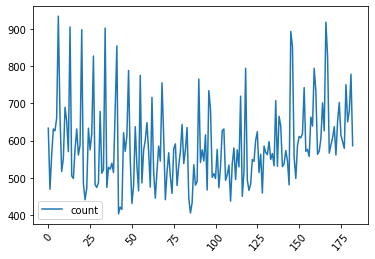

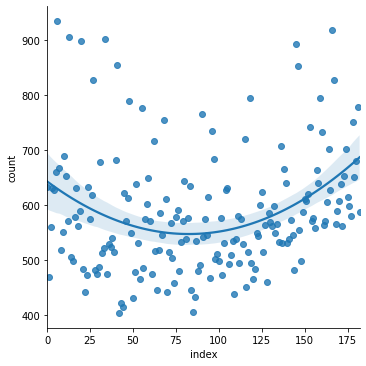

In [26]:
queen = grouped.filter(F.col("opening").contains("Queen's Gambit")) \
        .groupby("date").agg(F.sum(F.col("count")).alias("count")) \
        .sort(F.col("date"))
queen = queen.toPandas()
# queen = queen.set_index("date")
queen.plot.line(rot=50)
# display(HTML(queen.to_html()))
sns.lmplot(x="index",y='count',order=2, data=queen.reset_index(),fit_reg=True) 

## Sicilian Defense daily game count

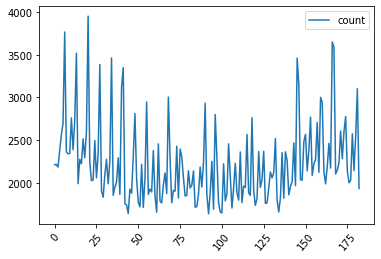

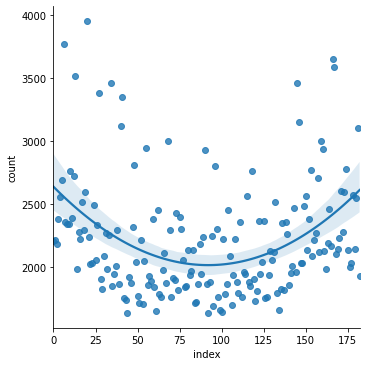

In [27]:
sicilian = grouped.filter(F.col("opening").contains("Sicilian Defense")) \
        .groupby("date").agg(F.sum(F.col("count")).alias("count")) \
        .sort(F.col("date"))
sicilian = sicilian.toPandas()
# sicilian = sicilian.set_index("date")
sicilian.plot.line(rot=50)
# display(HTML(sicilian.to_html()))
sns.lmplot(x="index",y='count',order=2, data=sicilian.reset_index(),fit_reg=True) 

## Queen's Gambit weekly game count

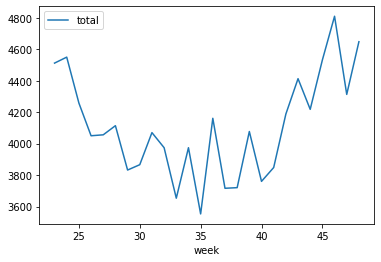

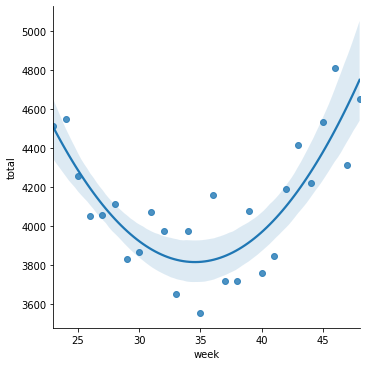

In [28]:
temp = grouped.filter(F.col("opening").contains("Queen's Gambit")) \
        .groupby(F.weekofyear(F.to_date(F.col("date"),"yyyy.MM.dd")).alias("week")) \
        .agg(F.sum(F.col("count")).alias("total")) \
        .sort(F.col("week")).toPandas()
temp.drop(temp.tail(1).index,inplace=True)
temp = temp.set_index("week")
temp.plot.line()
sns.lmplot(x="week",y='total',order=2, data=temp.reset_index(),fit_reg=True) 

## Sicilian Defense weekly game count

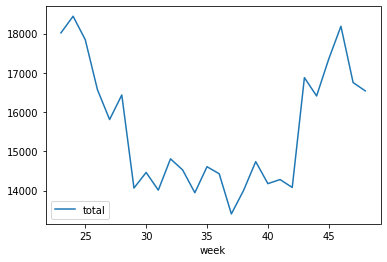

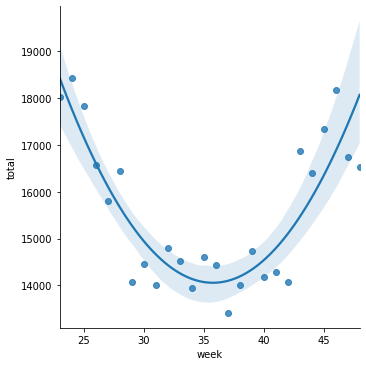

In [29]:
temp = grouped.filter(F.col("opening").contains("Sicilian Defense")) \
        .groupby(F.weekofyear(F.to_date(F.col("date"),"yyyy.MM.dd")).alias("week")) \
        .agg(F.sum(F.col("count")).alias("total"))\
        .sort(F.col("week")).toPandas()
temp.drop(temp.tail(1).index,inplace=True)
temp = temp.set_index("week")
temp.plot.line()
sns.lmplot(x="week",y='total',order=2, data=temp.reset_index(),fit_reg=True) 

## English Opening weekly game count after week 30

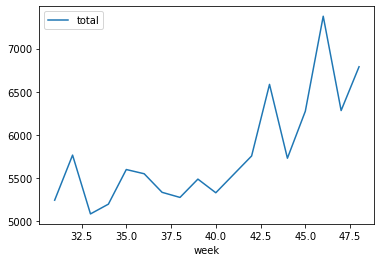

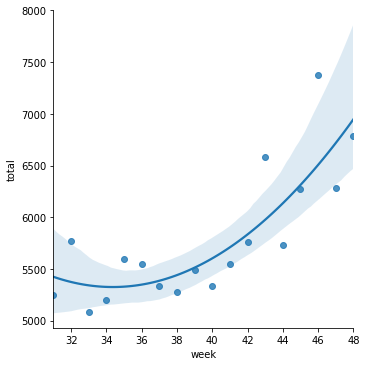

In [30]:
temp = grouped.filter(F.col("opening").contains("English Opening")) \
        .groupby(F.weekofyear(F.to_date(F.col("date"),"yyyy.MM.dd")).alias("week")) \
        .agg(F.sum(F.col("count")).alias("total")) \
        .sort(F.col("week")).filter(F.col("week") > 30).toPandas()
temp.drop(temp.tail(1).index,inplace=True)
temp = temp.set_index("week")
temp.plot.line()
sns.lmplot(x="week",y='total',order=2, data=temp.reset_index(),fit_reg=True) 

## Italian Game weekly game count after week 27

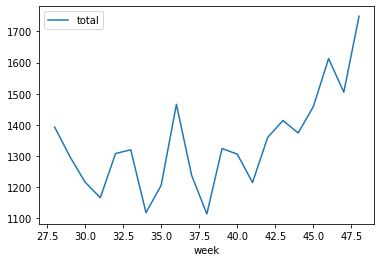

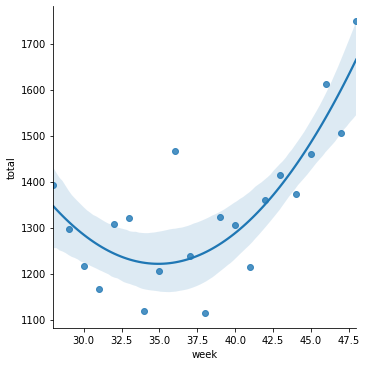

In [31]:
temp = grouped.filter(F.col("opening").contains("Italian Game")) \
        .groupby(F.weekofyear(F.to_date(F.col("date"),"yyyy.MM.dd")).alias("week")) \
        .agg(F.sum(F.col("count")).alias("total")) \
        .sort(F.col("week")).filter(F.col("week") > 27).toPandas()
temp.drop(temp.tail(1).index,inplace=True)
temp = temp.set_index("week")
temp.plot.line()
sns.lmplot(x="week",y='total',order=2, data=temp.reset_index(),fit_reg=True) 

## Weekly game count in all data

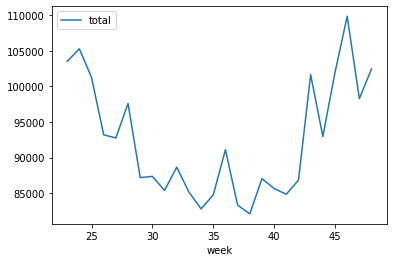

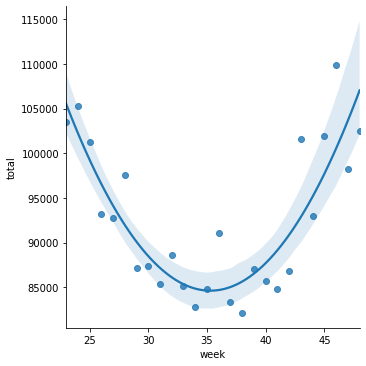

In [32]:
temp = total_games_weekly.sort(F.col("week")).toPandas()
temp.drop(temp.tail(1).index,inplace=True)
temp = temp.set_index("week")
temp.plot.line()
sns.lmplot(x="week",y='total',order=2, data=temp.reset_index(),fit_reg=True) 